In [1]:
from sample_psrs import load_psrs, fake_model_2a, fake_model_2a_no_tm
from pta_fast_model import FastLogLikelihood

import numpy as np

from enterprise.signals import utils
%load_ext autoreload
%autoreload 2

In [2]:
psrs = load_psrs(1e-15, 1)
pta0 = fake_model_2a(psrs)
pta = fake_model_2a_no_tm(psrs)

In [4]:
lnlikelihood = FastLogLikelihood(pta, psrs)

In [5]:
# %%timeit
lnlikelihood([0, -20, 0, -20, -20])

66411.96423799366

In [6]:
# %%timeit
pta.get_lnlikelihood([0, -20, 0, -20, -20])

-3496725.88812147

In [8]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import matplotlib.pyplot as plt

In [12]:
# sample the old way of doing things:
ndim = 5
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = './chains/true_data'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, outDir=outDir, resume=True)

N = int(1e6)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Resuming run from chain file ./chains/true_data/chain_1.txt
Adding DE jump with weight 50
/Users/aaron/opt/anaconda3/envs/enterprise/lib/python3.7/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))
Finished 99.90 percent in 2298.592119 s Acceptance rate = 0.242173
Run Complete


In [31]:
# sample the new way of doing things
ndim = 5
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = './chains/fast_data'

sampler = ptmcmc(ndim, lnlikelihood, pta.get_lnprior, cov, outDir=outDir, resume=True)

N = int(5e6)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Resuming run from chain file ./chains/fast_data/chain_1.txt
Adding DE jump with weight 50
Finished 2.00 percent in 2.944419 s Acceptance rate = 0.205483/Users/aaron/opt/anaconda3/envs/enterprise/lib/python3.7/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))
Finished 50.04 percent in 2243.143186 s Acceptance rate = 0.231291

KeyboardInterrupt: 

In [32]:
# load in chains
with open('./chains/true_data/chain_1.txt', 'r') as f:
    data0 = np.loadtxt(f)
with open('./chains/fast_data/chain_1.txt', 'r') as f:
    data1 = np.loadtxt(f)

In [33]:
burn = int(0.25 * data0.shape[0])
print(burn)

27775


In [34]:
gw_idx = list(pta.param_names).index('log10_A_gw')
import acor

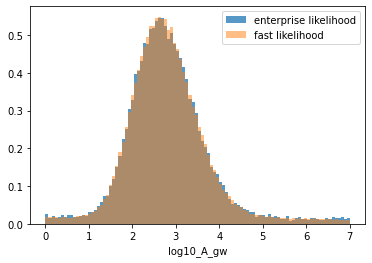

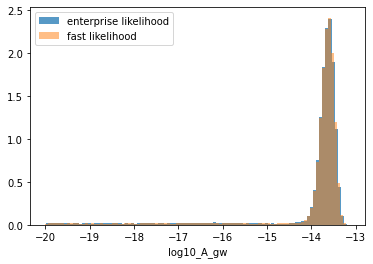

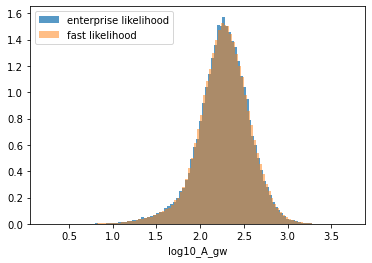

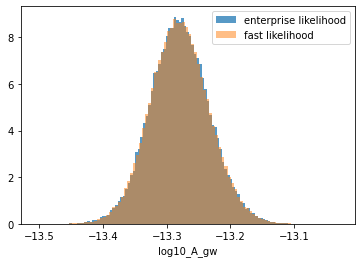

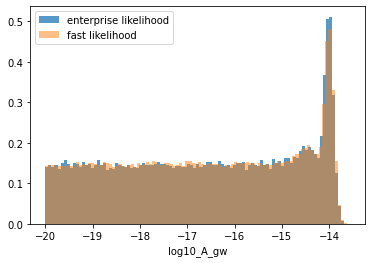

In [37]:

for ii in range(5):
    tau, __, __ = acor.acor(data0[burn:, ii])
    plt.hist(data0[burn:, ii], bins=100, density=True, alpha=0.75, label='enterprise likelihood')
    plt.hist(data1[burn:, ii], bins=100, density=True, alpha=0.5, label='fast likelihood')
    plt.xlabel('log10_A_gw')
    plt.legend()
    plt.savefig('test.png')
    plt.show()



In [17]:
def diff(x):
    return lnlikelihood(x) - pta.get_lnlikelihood(x)

In [38]:
diff([6, -15, 0, -20, -12])

-601.4308209816809